In [110]:
cp names.txt tmp.txt

In [142]:
!curl -O https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/male.txt
!curl -O https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/female.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20466  100 20466    0     0  45102      0 --:--:-- --:--:-- --:--:-- 45683
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35751  100 35751    0     0  78821      0 --:--:-- --:--:-- --:--:-- 79979


In [119]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt
from sklearn.decomposition import  PCA
from sklearn.manifold import TSNE
import numpy as np
import random

In [154]:
words = open("male.txt", "r").read().splitlines()[6:] + open("female.txt", "r").read().splitlines()[6:]
words = [w.lower() for w in words]
random.shuffle(words)

In [155]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: "'", 3: '-', 4: 'a', 5: 'b', 6: 'c', 7: 'd', 8: 'e', 9: 'f', 10: 'g', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'l', 16: 'm', 17: 'n', 18: 'o', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 't', 24: 'u', 25: 'v', 26: 'w', 27: 'x', 28: 'y', 29: 'z', 0: '.'}


In [156]:
context_length = 5

In [157]:
def make_dataset(words):
    X, y = [], []
    for w in words:
        context = [0] * context_length
        for ch in w + ".":
            X.append(context)
            y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X, y = torch.tensor(X), torch.tensor(y)
    return X, y

In [158]:
trl = len(words)
Xtr, ytr = make_dataset(words[:int(0.9*trl)])
Xte, yte = make_dataset(words[int(.9*trl):int(.95*trl)])
Xdev, ydev = make_dataset(words[int(0.95*trl):])

In [159]:
class Model1(nn.Module):
    def __init__(self, embd_dim):
        super().__init__()
        self.inp_dim = embd_dim * context_length
        self.C = nn.Embedding(len(itos), embd_dim)
        
        self.fc1 = nn.Linear(self.inp_dim, 4 * self.inp_dim)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(4 * self.inp_dim, self.inp_dim)
        self.fc3 = nn.Linear(self.inp_dim, len(itos))
        
    def forward(self, ix):
        x = self.C(ix).view(-1, self.inp_dim) # 16 * 5
        
        h = self.fc1(x)
        h = self.gelu(h)
        h = self.fc2(h)
        h = self.gelu(h)
        h = self.fc3(h)
        return h

In [160]:
model = Model1(16)

In [162]:
# Training loop
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
losses = []

for step in range(10000):
    optimizer.zero_grad()
    ix = torch.randint(0, Xtr.shape[0], (32,))
    logits = model(Xtr[ix])
    loss = F.cross_entropy(logits, ytr[ix])
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if step % 1000 == 0:
        print(f"{step=}, {loss=}")

step=0, loss=tensor(3.4073, grad_fn=<NllLossBackward0>)
step=1000, loss=tensor(2.4242, grad_fn=<NllLossBackward0>)
step=2000, loss=tensor(2.2807, grad_fn=<NllLossBackward0>)
step=3000, loss=tensor(2.3495, grad_fn=<NllLossBackward0>)
step=4000, loss=tensor(2.4600, grad_fn=<NllLossBackward0>)
step=5000, loss=tensor(1.7362, grad_fn=<NllLossBackward0>)
step=6000, loss=tensor(2.1351, grad_fn=<NllLossBackward0>)
step=7000, loss=tensor(2.0929, grad_fn=<NllLossBackward0>)
step=8000, loss=tensor(2.4725, grad_fn=<NllLossBackward0>)
step=9000, loss=tensor(2.2073, grad_fn=<NllLossBackward0>)


In [163]:
# Visualization

In [164]:
weight = next(model.named_parameters())[1].detach().numpy()

In [165]:
norm = np.linalg.norm(weight, axis=1)
norm_matrix = norm[:, None] * norm[None, :]
cosin_distance = (weight @ weight.T) / norm_matrix

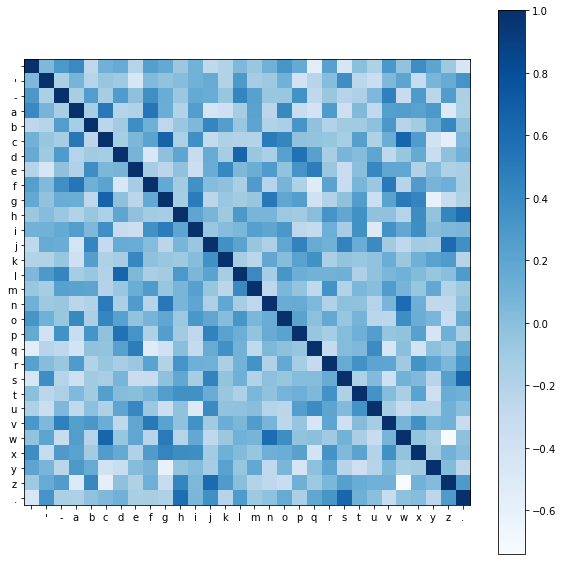

In [166]:
plt.figure(figsize=(10,10))
plt.imshow(cosin_distance, cmap="Blues")
plt.colorbar()
plt.xticks(np.arange(len(itos)), labels=list(itos.values()));
plt.yticks(np.arange(len(itos)), labels=list(itos.values()));

In [167]:
pca = PCA(n_components=2)
vis = pca.fit_transform(weight)

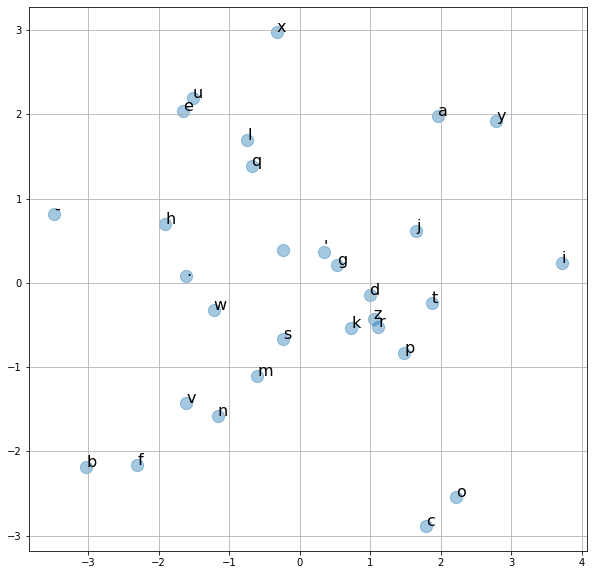

In [170]:
plt.figure(figsize=(10,10))
plt.scatter(vis[:, 0], vis[:, 1], s=150, alpha=0.4)
plt.grid(True)
for ix, char in itos.items():
    plt.annotate(char, vis[ix], fontsize=16)

In [169]:
C = next(model.named_parameters())[1].detach()

In [171]:
# Sample

for _ in range(20):
    out = []
    context = [0] * context_length
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mader.
eytonne.
digem.
eda.
mobin.
emni.
ilal.
cowlie.
aisso.
panto.
heva.
paoda.
seled.
delista.
hadetipi.
hennirkse.
karisa.
andait.
merttanea.
gestpa.
